In [2]:
import rerun as rr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import scipy
%matplotlib inline

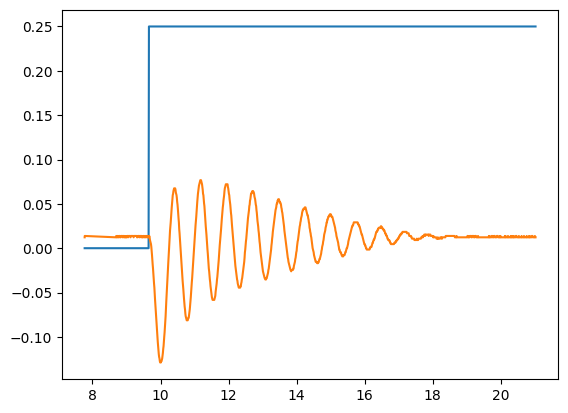

In [ ]:
path_to_rrd = "./step_inv.rrd"
recording = rr.dataframe.load_recording(path_to_rrd)
batches = recording.view(index="sample_time", contents="/**").select()
df: pd.DataFrame = batches.read_pandas()

Ts = 0.01
ts = df['sample_time'].to_numpy().astype(np.float64) / 1e9
pend_angle = np.concatenate(df['/sensor_pend_angle:Scalar'].to_numpy())
control = np.concatenate(df['/control:Scalar'].to_numpy())
plt.plot(ts, control)
plt.plot(ts, pend_angle)

In [66]:
Iflywheel = 277.4
est_m = 0.134
mstang = 0.038
Istang = 268.95 * mstang/est_m
rcg = 45.7
mwheel = 0.063
mmotor = 0.113
rout = 150 # mm
Ieverything = rcg**2*mstang + Istang + (mwheel*mmotor)*rout**2 + Iflywheel
rotratio = Iflywheel/Ieverything
rotratio

0.467625668927401

0.145
2 states have been removed from the model


StateSpace(array([[ 9.99066188e-01, -7.27152446e-02,  1.19283251e-03],
       [-9.28267136e-02,  1.00269873e+00,  1.30449897e-03],
       [ 4.29373259e-19, -3.32122374e-18,  9.86755162e-01]]), array([[-0.00922112],
       [ 0.00042966],
       [ 0.09940391]]), array([[ 0.00000000e+00,  0.00000000e+00,  5.32970502e+00],
       [ 0.00000000e+00, -2.49357892e+00, -1.69727207e-03],
       [ 3.42602698e-01, -1.59177451e-02,  3.18084153e-02]]), array([[0.],
       [0.],
       [0.]]), 0.01)

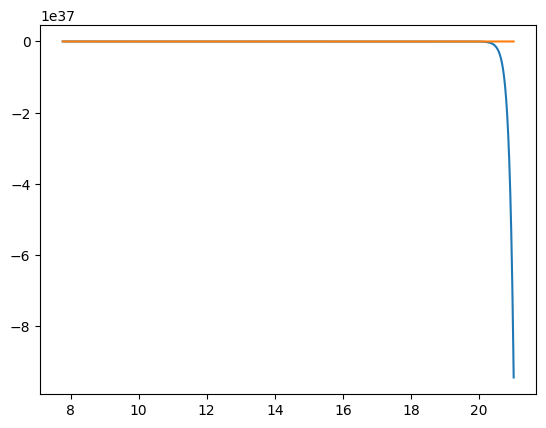

In [93]:
T = 0.75
K = 40
g = 9.81
#r = (0.150*(mwheel + mmotor) + rcg/1000 * mstang) /(mwheel + mmotor + mstang)
#r = 0.150 # real distance from axis, but the center of mass is closer to the roation axis
r = 0.145
print(r)

Gmotor = ct.tf([K], [T, 1])
RtoTheta = ct.tf([-rotratio,0], [1, 0.5, -g / r]) * Gmotor

deriv = ct.tf([1], [1,0])
integral = ct.tf([1], [1, 0])

ident = ct.tf([1], [1])
sys = ct.minreal(ct.interconnect(
    [ident, Gmotor, RtoTheta, deriv],
    name="system",
    connections=[
        [(1, 0), (0, 0)],
        [(2, 0), (0, 0)],
        [(3, 0), (2, 0)],
    ],
    inplist=(0, 0),
    outlist=[(1, 0), (2, 0), (3, 0)],
))
sysd = ct.c2d(sys, Ts)

resp = ct.forced_response(sysd, U=control)

plt.plot(ts, resp.y[1])
plt.plot(ts, pend_angle - 0.0123)
sysd


In [ ]:
G = np.array([
    [1**2, 0.0, 0.0],
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 100.0**2],
])
Qflat = np.linalg.pinv(np.kron(sysd.C, sysd.C))@G.T.reshape(9,-1)
Q = Qflat.reshape((3,3)).T
Q

array([[ 8.51958809e+02,  2.22546701e-06, -3.26958636e-03],
       [ 2.22546701e-06,  1.63098645e-08, -2.39619414e-05],
       [-3.26958636e-03, -2.39619414e-05,  3.52041331e-02]])

In [116]:
Q1 = (
    sysd.C.T @ np.array([
        [0.00000, 0.0, 0.0],
        [0.0, 1.0, 0.0],
        [0.0, 0.0, 0.000]
    ]) @ sysd.C
)
Q2 = np.array([
    [1.0]
])

K, L, G = ct.dare(sysd.A, sysd.B, Q1, Q2)

In [120]:

def export_mat(mat: np.ndarray):
    mat = mat.T
    rows, cols = mat.shape
    return "[{}]".format(','.join( '[' + ','.join( str(mat[row,col]) for col in range(cols) ) + ']' for row in range(rows)) )
rust_code = """
A: {}.into(),
B: {}.into(),
C: {}.into(),
D: {}.into(),
Q: {}.into(),
""".format(*(export_mat(a) for a in [sysd.A, sysd.B, sysd.C, sysd.D]), export_mat(Q))
print(rust_code)

print(export_mat(G))


A: [[0.9990661876105708,-0.09282671358624058,4.2937325870569804e-19],[-0.07271524461036599,1.002698728873369,-3.3212237385430993e-18],[0.0011928325090661347,0.0013044989681259072,0.9867551618071957]].into(),
B: [[-0.009221120487808532,0.00042966099160485807,0.09940391188050599]].into(),
C: [[0.0,0.0,0.34260269786748027],[0.0,-2.4935789245789506,-0.01591774505100323],[5.3297050155233245,-0.001697272074671315,0.03180841531133949]].into(),
D: [[0.0,0.0,0.0]].into(),
Q: [[851.958808893405,2.225467005106603e-06,-0.0032695863581275937],[2.225467005221837e-06,1.630986447586874e-08,-2.3961941400029948e-05],[-0.003269586358127599,-2.3961941399919556e-05,0.03520413312548506]].into(),

[[1.0,0.0,0.0],[0.0,0.0,0.0],[0.0,0.0,100.0]]
